# Other input parameters
As a next step, we want to implement the logicle function in a way that the user does not need to specify the unintuitive parameters  $T, W, A, M$ on their own, but just give more intuitive and clear parameters.
This are the top of the scale $T$ and the value, at which he wants the transition from linear to logarithm, $trans$.
We implement the function for parameter spaces, that are starting at zero and have negative values only due to noise effects. That means that we set $A = -W$ by default, so that we are not including negative values, but $0$ is on scale.

In order to complete the four parameters we fix the parameter $M=4.5$ (if not specified different) and calculate the last parameter $W$ corresponding to the specified parameter $trans$. It is recommended in the publication that the parameter that is varied should be $W$ rather than any other.

Since $W$ is the linearization width (in positive direction) and $M$ the width of the logicle display, we know that on the display scaled to $[0,1]$ the transition occurs at
$$
transition.scaled = \frac{W}{M-W},
$$
where $transition.scaled=logicle(trans)$.
This means we can find the parameter $W$ by solving 
$$0=logicle(trans)-\frac{W}{W-M}.$$
(Note that the logicle function depends on $W$) 
We solve this equation numerically usingthe newton method from scipy.optimize.

In [2]:
import numpy as np
import sys
import scipy
from scipy.optimize import fsolve
import matplotlib.pyplot as plt

In [3]:
def solve_d (w,b):
    if w==0:
        return b
    def g(x):
        g = w*(b+x)+2*(np.log(x)-np.log(b))
        return g
    d = fsolve(g, b)
    return d

# function to compute linear region width
def compute_W(T, trans, M):
    from scipy.optimize import newton
    h = lambda W: (W/(M-W))-logicleTransform(trans, T=T, W=float(W), M=M)

    W = newton(h,  0.5, tol=1e-10)
    return W

def function_parameters(T, trans=None, W=None, A=None, M=None):
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a 

    return [x0, x1, x2, a, b, c, d, f, w, T, W, A, M]

def biexponentialTaylorSeries(scaled, T, W, A, M):

    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a
    
    order = 16 # order of taylor series is 16

    posCoef = a*np.exp(b*x1)
    negCoef = -c*np.exp(-d*x1)
    taylorCoef = np.zeros(order)

    for i in range(order):
        posCoef = posCoef*(b/(i+1))
        negCoef = negCoef*(-d/(i+1))
        taylorCoef[i] = posCoef + negCoef
    taylorCoef[1]=0 # ensuring that the second derivative is 0 (logicle condition)    

    x = scaled - x1
    sum = 0

    for i in range(order): 
        sum = (sum + taylorCoef[order-1-i])*x 
        
    return sum

In [4]:
def logicleTransform(par, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    # check parameter conditions
    if T <= 0:
    	sys.exit("T is not positive")

    if W < 0:
	    sys.exit("W is negative")

    if M <= 0:
	    sys.exit("M is not positive")

    if 2 * W > M:
	    sys.exit("W is too large")

    if -A > W or A + W > M - W:
	    sys.exit("A is too large")

    # compute parameters for biexponential function
    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a 



    def logicleTransform1d(value):
        if value==0: # exclude exact zero value
            return x1

        negative = value<0
        if negative:
            value = -value
    
        if value < f:
          x = x1+(value/(a*b*np.exp(b*x1)+c*d*np.exp(-d*x1))) # later use taylorCoef[0]?!
    
        if value >= f:
          x = np.log(value/a)/b # in original implementation other condition, why?
    
        tolerance = 1e-10 # set tolerance for convergence
        n_steps = 50 # set maximal number of steps for Halley's method
        taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series

        for i in range(n_steps):
            step = i
            first_term = a*np.exp(b*x)
            second_term = c*np.exp(-d*x)

            if x < taylor_treshold:
                y = biexponentialTaylorSeries(x,  T, W, A, M) - value
            else:
                y = first_term-second_term+f - value
            dy = b*first_term + d*second_term
            ddy = b*b*first_term - d*d*second_term

            delta = y/(dy-((y*ddy)/(2*dy)))
            x = x - delta

            if np.absolute(delta) < tolerance:
                if negative:
                    return 2*x1-x
                else:
                    return x
                
        sys.exit("Scale did not converge!")
   
    if np.ndim(par)==0:
        logicle_par = logicleTransform1d(par)
    else:
        length = len(par)
        logicle_par = np.zeros(length)

        for i in range(length):
            logicle_par[i] = logicleTransform1d(par[i])
    
    return logicle_par

In [5]:
def logicleInverseTransform(scaled, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    # check parameter conditions
    if T <= 0:
    	sys.exit("T is not positive")

    if W < 0:
	    sys.exit("W is negative")

    if M <= 0:
	    sys.exit("M is not positive")

    if 2 * W > M:
	    sys.exit("W is too large")

    if -A > W or A + W > M - W:
	    sys.exit("A is too large")

    # compute parameters for biexponential function
    b = (M+A)*np.log(10)
    w = W/(M+A)
    x2 = A/(M+A)
    x1 = x2 + w
    x0 = x1 + w
    d = solve_d(w,b)
    c_a = np.exp(x0*(b+d))
    mf_a = np.exp(b*x1)- (c_a/np.exp(d*x1)) 
    a = T / ((np.exp(b) - mf_a) - (c_a / np.exp(d)))
    c = c_a * a 
    f = -mf_a * a


    def logicleInverseTransform1d(scaled):
        negative = scaled < x1

        if negative:
            scaled = 2*x1-scaled   # reflect negative region
    
        taylor_treshold = x1 + w/4 # threshold for neighbourhood of x1 in which we apply taylor series (include in logicle object?)

        if scaled < taylor_treshold:
            inverse = biexponentialTaylorSeries(scaled, T, W, A, M)
        else:
            inverse = a*np.exp(b*scaled)-c*np.exp(-d*scaled)+f

        if negative:
            return - inverse
        else:
            return inverse


    if np.ndim(scaled)==0:
        inverse = logicleInverseTransform1d(scaled)
    else:
        length = len(scaled)
        inverse = np.zeros(length)

        for i in range(length):
            inverse[i] = logicleInverseTransform1d(scaled[i])

    
    return inverse

In [6]:
par = np.linspace(0,1e3,10**5)
T = 1000
trans = 1e-3
logicle_par = logicleTransform(par, T=T, trans=trans) 


In [7]:
# getting the transition point
x0 = function_parameters(T=1000, trans=trans)[0]
transition = logicleInverseTransform(x0, T=1000, trans=trans)
transition

array([0.001])

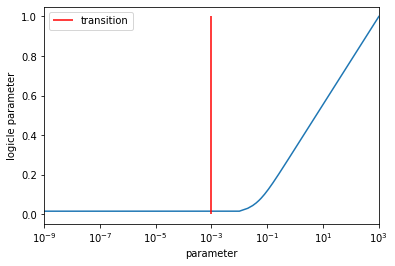

In [8]:
plt.plot(par, logicle_par)
plt.vlines(transition, 0, 1, color='red', label='transition')
plt.xlabel("parameter")
plt.ylabel("logicle parameter")
plt.xscale('log')
plt.xlim(1e-9,1e3)
plt.legend()
plt.show()

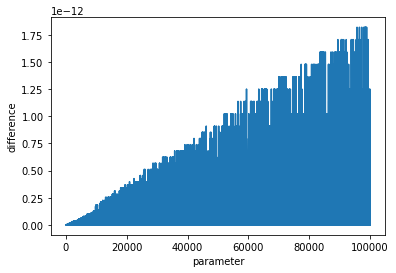

In [9]:
# compute inverse and differences

inv_par_logicle = logicleInverseTransform(scaled=logicle_par, T=T, trans= trans)

diff = np.abs(inv_par_logicle - par)

plt.plot(diff)
plt.xlabel('parameter')
plt.ylabel('difference')
plt.show()

Next step is to compute the gradient of the logicle function in order to pass it to the `create objective` function in pypesto later.>
For the inverse of the logicle function this is easy since we can just differentiate the biexponential function. 
For the Logicle function this is not as easy, so we calculate it with centered finite differences.

In [10]:
def logicleInverseGradient(scaled, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    fun_param = function_parameters(T, trans, W, A, M)
    a = fun_param[3]
    b = fun_param[4]
    c = fun_param[5]
    d = fun_param[6]
    if isinstance(scaled, list):
        scaled = np.array(scaled)
    
    return a * b * np.exp(b * scaled) + c * d * np.exp(-d * scaled)

def logicleGradient(par, T, trans=None, W=None, A=None, M=None):
    # set missing parameters
    if M is None:
        M = 4.5

    if W is None:
        W = compute_W(T, trans, M)

    if A is None:
        A = -W

    stepsize = 1e-5

    grad = np.zeros(len(par))

    for i in range(0, len(par)):

        upper = logicleTransform(np.array([par[i]]) + stepsize, trans=trans, T=T, W=W, A=A, M=M)
        lower = logicleTransform(np.array([par[i]]) - stepsize, trans=trans, T=T, W=W, A=A, M=M)
        grad[i] = (upper - lower) / (2 * stepsize)
    
    return grad

In [11]:
# compute gradient
logicle_gradient = logicleGradient(par, T=1000, trans = trans)

1.4932717295001197


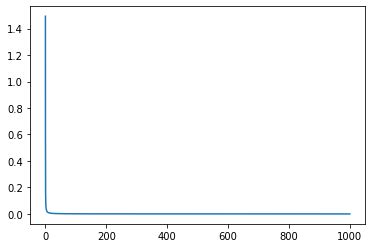

In [12]:
print(logicle_gradient[0])

# display logicle gradient
plt.plot(par, logicle_gradient)
plt.show()

Next we plot it against a linear and a logarithmic function, to see how it approximates them in for small respectively for large parameter values.

/tmp/ipykernel_1504/1881545037.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.plot(par, np.log10(par)-2, 0, 1, color='red', label='logarithm')


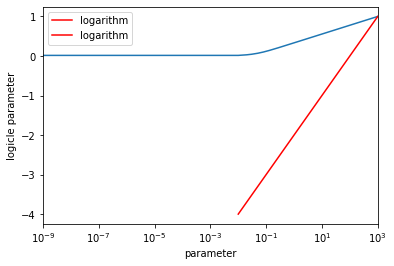

In [16]:
plt.plot(par, logicle_par)
plt.plot()
plt.xlabel("parameter")
plt.ylabel("logicle parameter")
plt.xscale('log')
plt.xlim(1e-9,1e3)
plt.legend()
plt.show()

Maybe try it later sometime...